In [33]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "./spark-3.1.2-bin-hadoop2.7"
get_ipython().system_raw('pip install pandas')
get_ipython().system_raw('pip install findspark')
get_ipython().system_raw('pip install matplotlib')
import findspark
findspark.init()

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

#get_ipython().system_raw('./ngrok config add-authtoken YOUR_AUTHTOKEN')
get_ipython().system_raw('./ngrok http 4050 &')

NAME:
  http - start an HTTP tunnel

USAGE:
  ngrok http [address:port | port] [flags]

DESCRIPTION: 
  Starts a tunnel listening for HTTP/HTTPS traffic with a specific hostname.
  The HTTP Host header on incoming public requests is inspected to
  determine which tunnel it matches.

  HTTPS endpoints terminate TLS traffic at the ngrok server using the
  appropriate certificates. The decrypted, HTTP traffic is then forwarded
  through the secure tunnel and then to your local server. If you don't want
  your TLS traffic to terminate at the ngrok server, use a TLS or TCP tunnel.

TERMS OF SERVICE: https://ngrok.com/tos

EXAMPLES: 
  ngrok http 8080                             # forward ngrok subdomain to port 80
  ngrok http example.com:9000                 # forward traffic to example.com:9000
  ngrok http --domain=bar.ngrok.dev 80        # request subdomain name: 'bar.ngrok.dev'
  ngrok http --domain=example.com 1234        # request tunnel 'example.com' (DNS CNAME)
  ngrok http --basic


ERROR:  authentication failed: Your account is limited to 1 simultaneous ngrok agent session.
ERROR:  You can run multiple tunnels on a single agent session using a configuration file.
ERROR:  To learn more, see https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config/
ERROR:  
ERROR:  Active ngrok agent sessions in region 'sa':
ERROR:    - ts_2WEHH4YgQ0Ms3MlAKiWPTFkoZWr (191.179.19.103)
ERROR:  
ERROR:  ERR_NGROK_108
ERROR:  


In [67]:
path = './data/clothes_dataset.csv'
roupas = spark.read.csv(path, sep=',', inferSchema=True)

import pandas
roupas.show()

+--------------------+------------+---+------------+-----+--------------------+--------------------+-------------------+---------------+----+----+
|                 _c0|         _c1|_c2|         _c3|  _c4|                 _c5|                 _c6|                _c7|            _c8| _c9|_c10|
+--------------------+------------+---+------------+-----+--------------------+--------------------+-------------------+---------------+----+----+
|Pijama Cirurgico ...|  R$  69,90 | 0%|  R$  69,90 | 1000|TORONTO UNIFORMES...|           Poliéster|         Sem gênero|            N/A|   4| 273|
|Kit 10 Cuecas Box...| R$  274,81 |18%| R$  232,89 |10000|                Lupo|             Algodão|          Masculino| Outono/Inverno| 4,5|3034|
|Kit Com 10 Cuecas...| R$  239,88 |20%| R$  199,90 |50000|               Zorba|             Algodão|          Masculino|            N/A| 4,7|5682|
|Kit 10 Cuecas Box...| R$  279,86 |22%| R$  229,39 |10000|                Mash|             Algodão|          Masculin

In [68]:
roupasColNames = [
    'titulo', 
    'preco_original', 
    'desconto_percentual', 
    'preco_com_desconto', 
    'n_vendidos_categoria', 
    'marca', 
    'material',
    'gênero',
    'temporada',
    'nota',
    'n_avaliações'
]
for index, colname in enumerate(roupasColNames):
    roupas = roupas.withColumnRenamed(f"_c{index}", colname)

roupas = roupas.na.drop("any")
roupas.toPandas()

,titulo,preco_original,desconto_percentual,preco_com_desconto,n_vendidos_categoria,marca,material,gênero,temporada,nota,n_avaliações
0,Pijama Cirurgico Scrub Roupa Privativa Hospit...,"R$ 69,90",0%,"R$ 69,90",1000,TORONTO UNIFORMES PROFISSIONAIS,Poliéster,Sem gênero,N/A,4,273
1,Kit 10 Cuecas Boxer Lupo Cueca Box Algodão Mas...,"R$ 274,81",18%,"R$ 232,89",10000,Lupo,Algodão,Masculino,Outono/Inverno,"4,5",3034
2,Kit Com 10 Cuecas Boxer Algodão Sem Costura Zo...,"R$ 239,88",20%,"R$ 199,90",50000,Zorba,Algodão,Masculino,N/A,"4,7",5682
3,Kit 10 Cuecas Boxer Mash Algodão Cotton Box Or...,"R$ 279,86",22%,"R$ 229,39",10000,Mash,Algodão,Masculino,Primavera/Verão,"4,6",1700
4,Kit 3 Short Jeans Feminino Cintura Alta Barato...,"R$ 140,83",9%,"R$ 129,20",1000,Menina Linda,Jean,Feminino,Primavera/Verão,"4,4",507
...,...,...,...,...,...,...,...,...,...,...,...
1554,Kit 4 Bermudas Plusais Estampada Caminhada Ult...,"R$ 117,58",11%,"R$ 105,93",25,Feminina Academia Atacado,Poliéster,Feminino,Primavera/Verão,"2,3",4
1555,Roupinha Bebê Ensaio Newborn Body Laço E Faixa...,"R$ 42,00",0%,"R$ 42,00",100,Roupinha Para Ensaio,N/A,Bebês,N/A,"4,4",34
1556,Calça Levi´s 511 Slim Com Elastano Ref Lb5110018,"R$ 318,90",0%,"R$ 318,90",100,Levi's,Algodão com elastano,Masculino,Outono/Inverno,"4,5",14
1557,Bermuda Masculina Tática Thunder Poly Ripstop ...,"R$ 131,78",10%,"R$ 119,80",5,Use Tático,Poliéster,Masculino,Primavera/Verão,"4,3",3


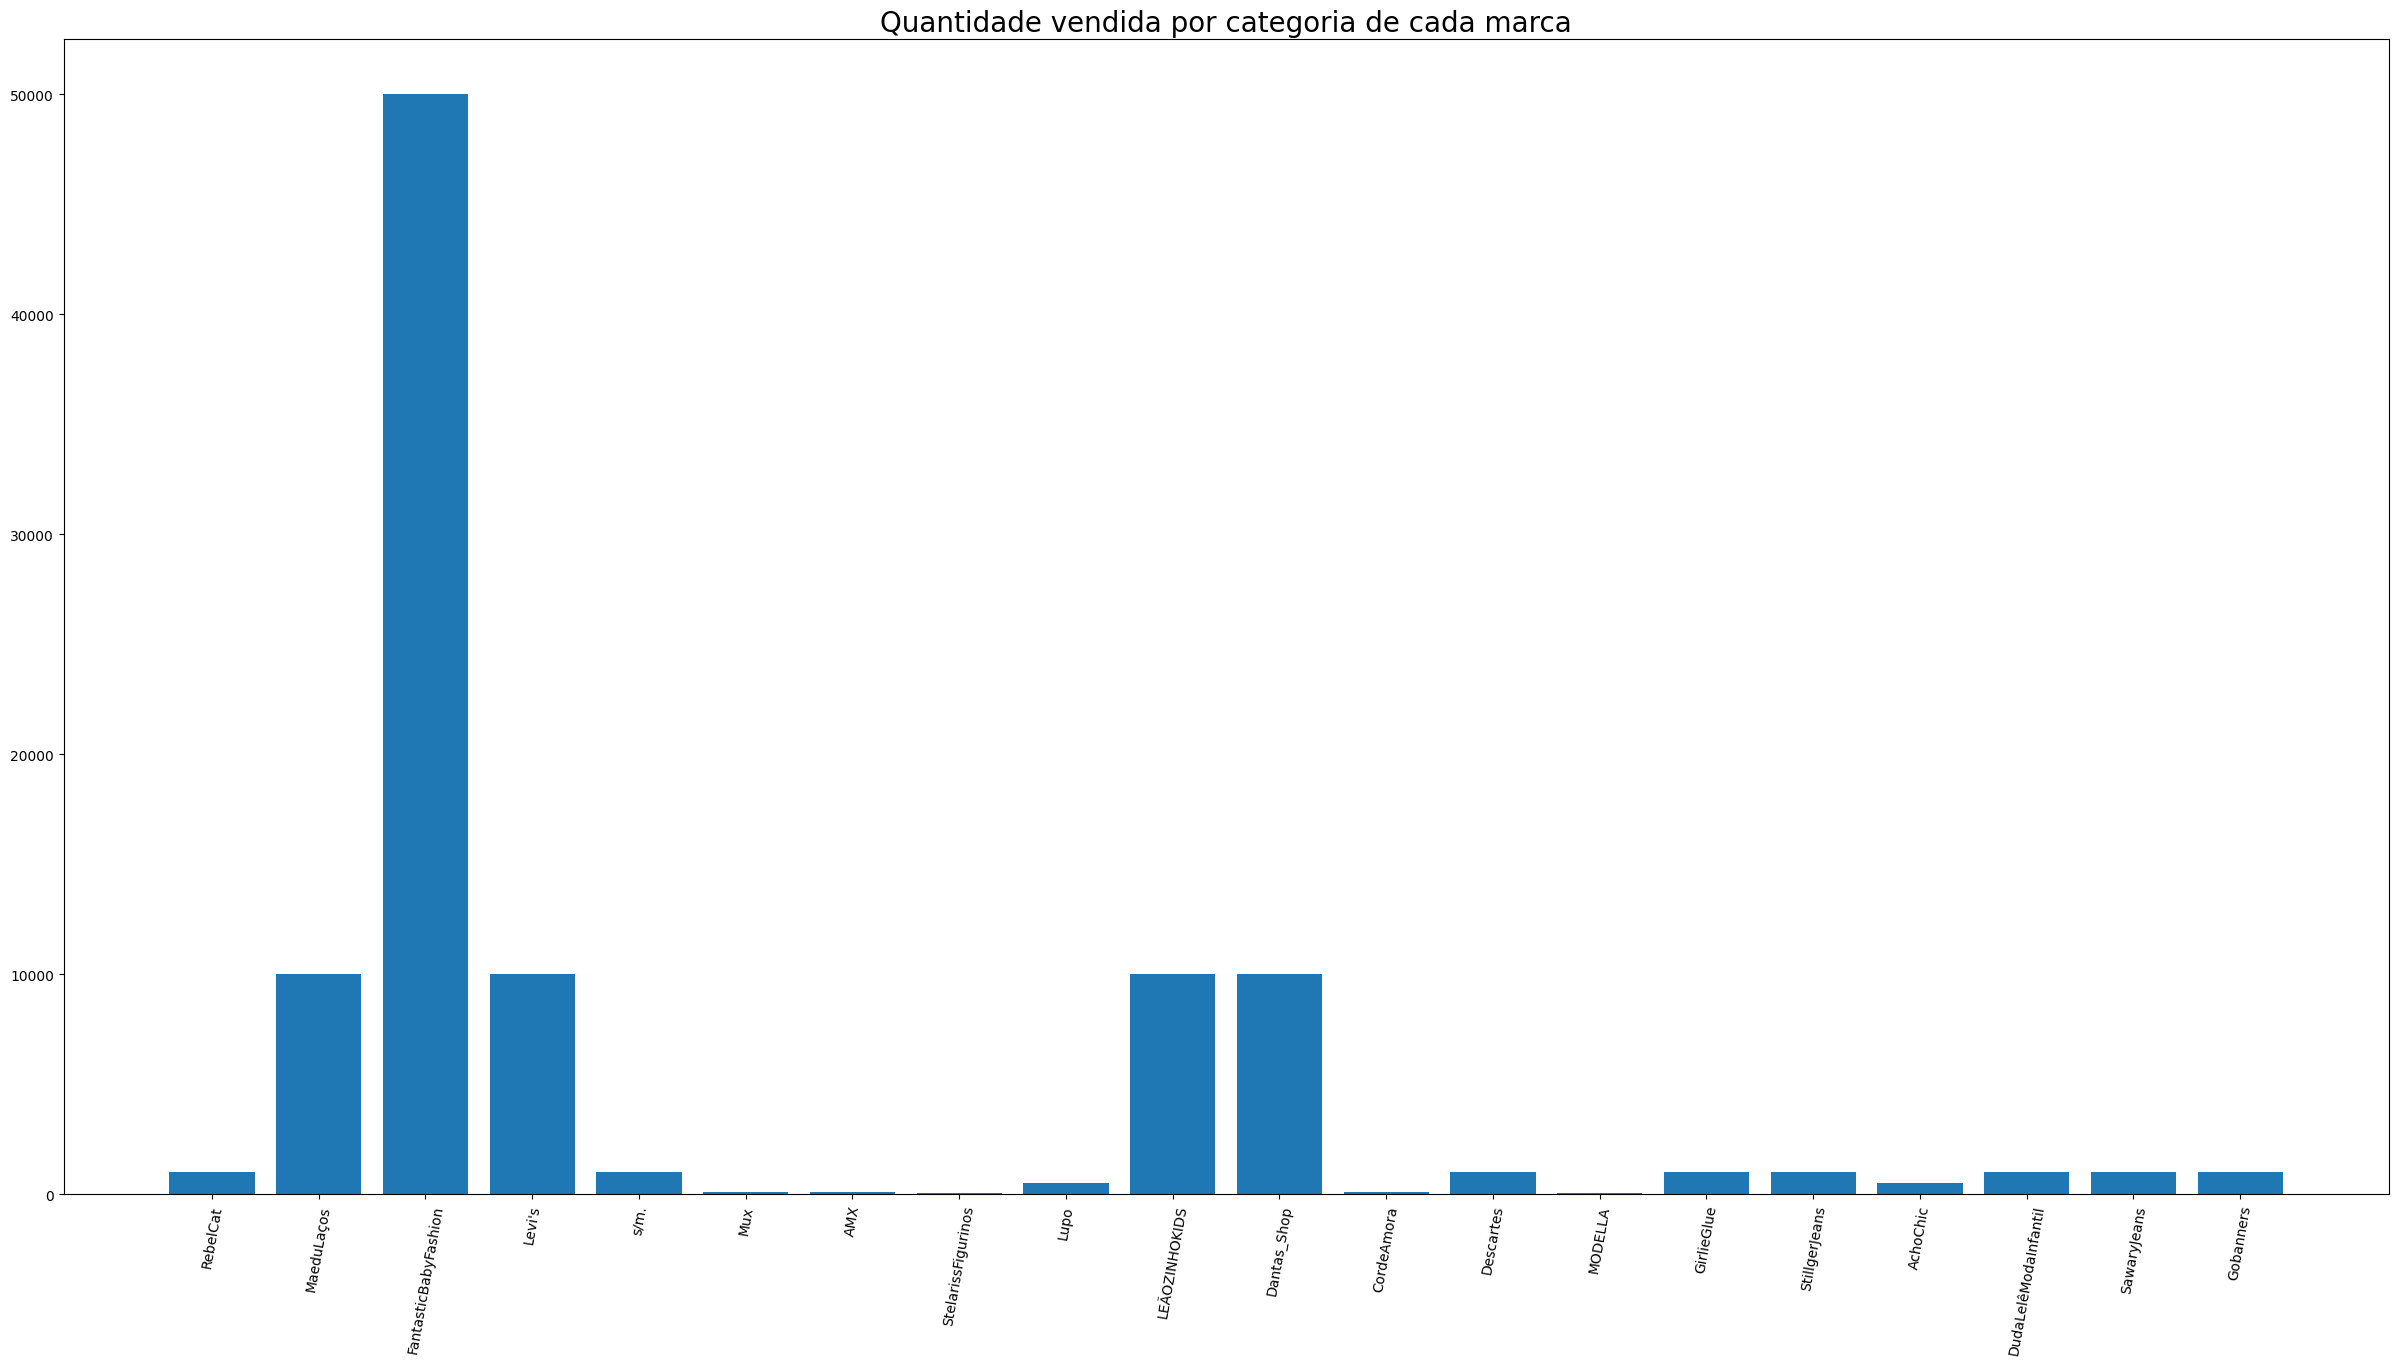

In [162]:
from matplotlib import pyplot as plt
import numpy as np

valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(20).select("marca").collect()
]
valores_y = [
    float(row[0]) for row in
    roupas.na.drop("any").limit(20).select("n_vendidos_categoria").collect()
]




plt.figure(figsize=(30, 15))
plt.title("Quantidade vendida por categoria de cada marca", fontsize=20)
plt.bar(valores_x, valores_y)
plt.xticks(rotation=80)
plt.show()


In [128]:
get_ipython().system_raw('pip install squarify')

/home/thiago/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2607: UserWarning: You executed the system command !pip which may not work as expected. Try the IPython magic %pip instead.
  warnings.warn(


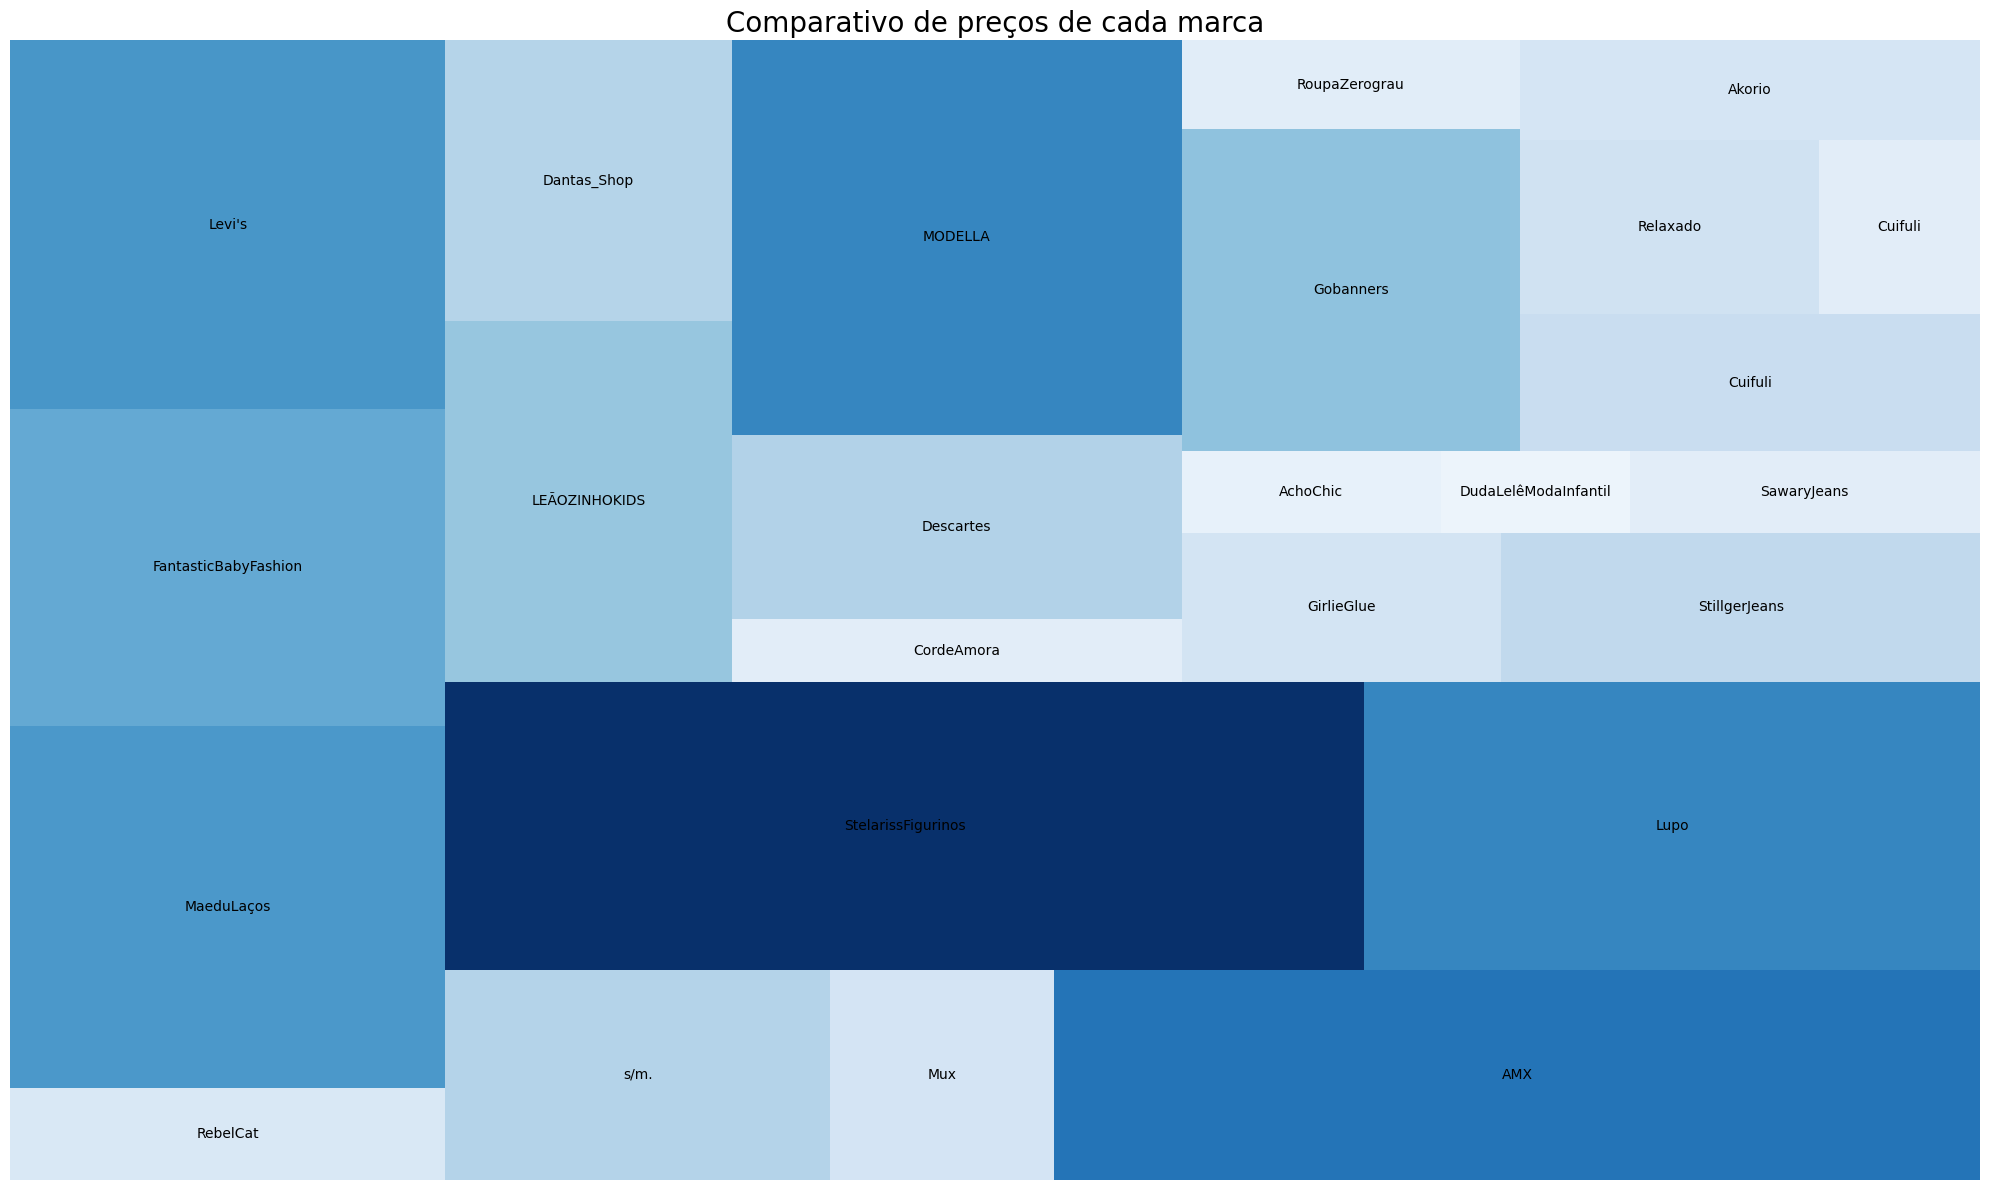

In [154]:
import matplotlib
import squarify
valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(25).select("marca").collect()
]
valores_y = [
    float(row[0].replace(' R$ ', '').replace(' ','').replace(',','.')) for row in
    roupas.limit(25).select("preco_original").collect()
]

# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.Blues
maxi = max(valores_y)
norm = matplotlib.colors.Normalize(vmin=0, vmax=maxi)
colors = [cmap(norm(i)) for i in valores_y]

plt.figure(figsize=(20, 12))
squarify.plot(sizes=valores_y, label=valores_x, color=colors);
plt.title('Comparativo de preços de cada marca', fontsize=20)
plt.axis('off');
plt.tight_layout()

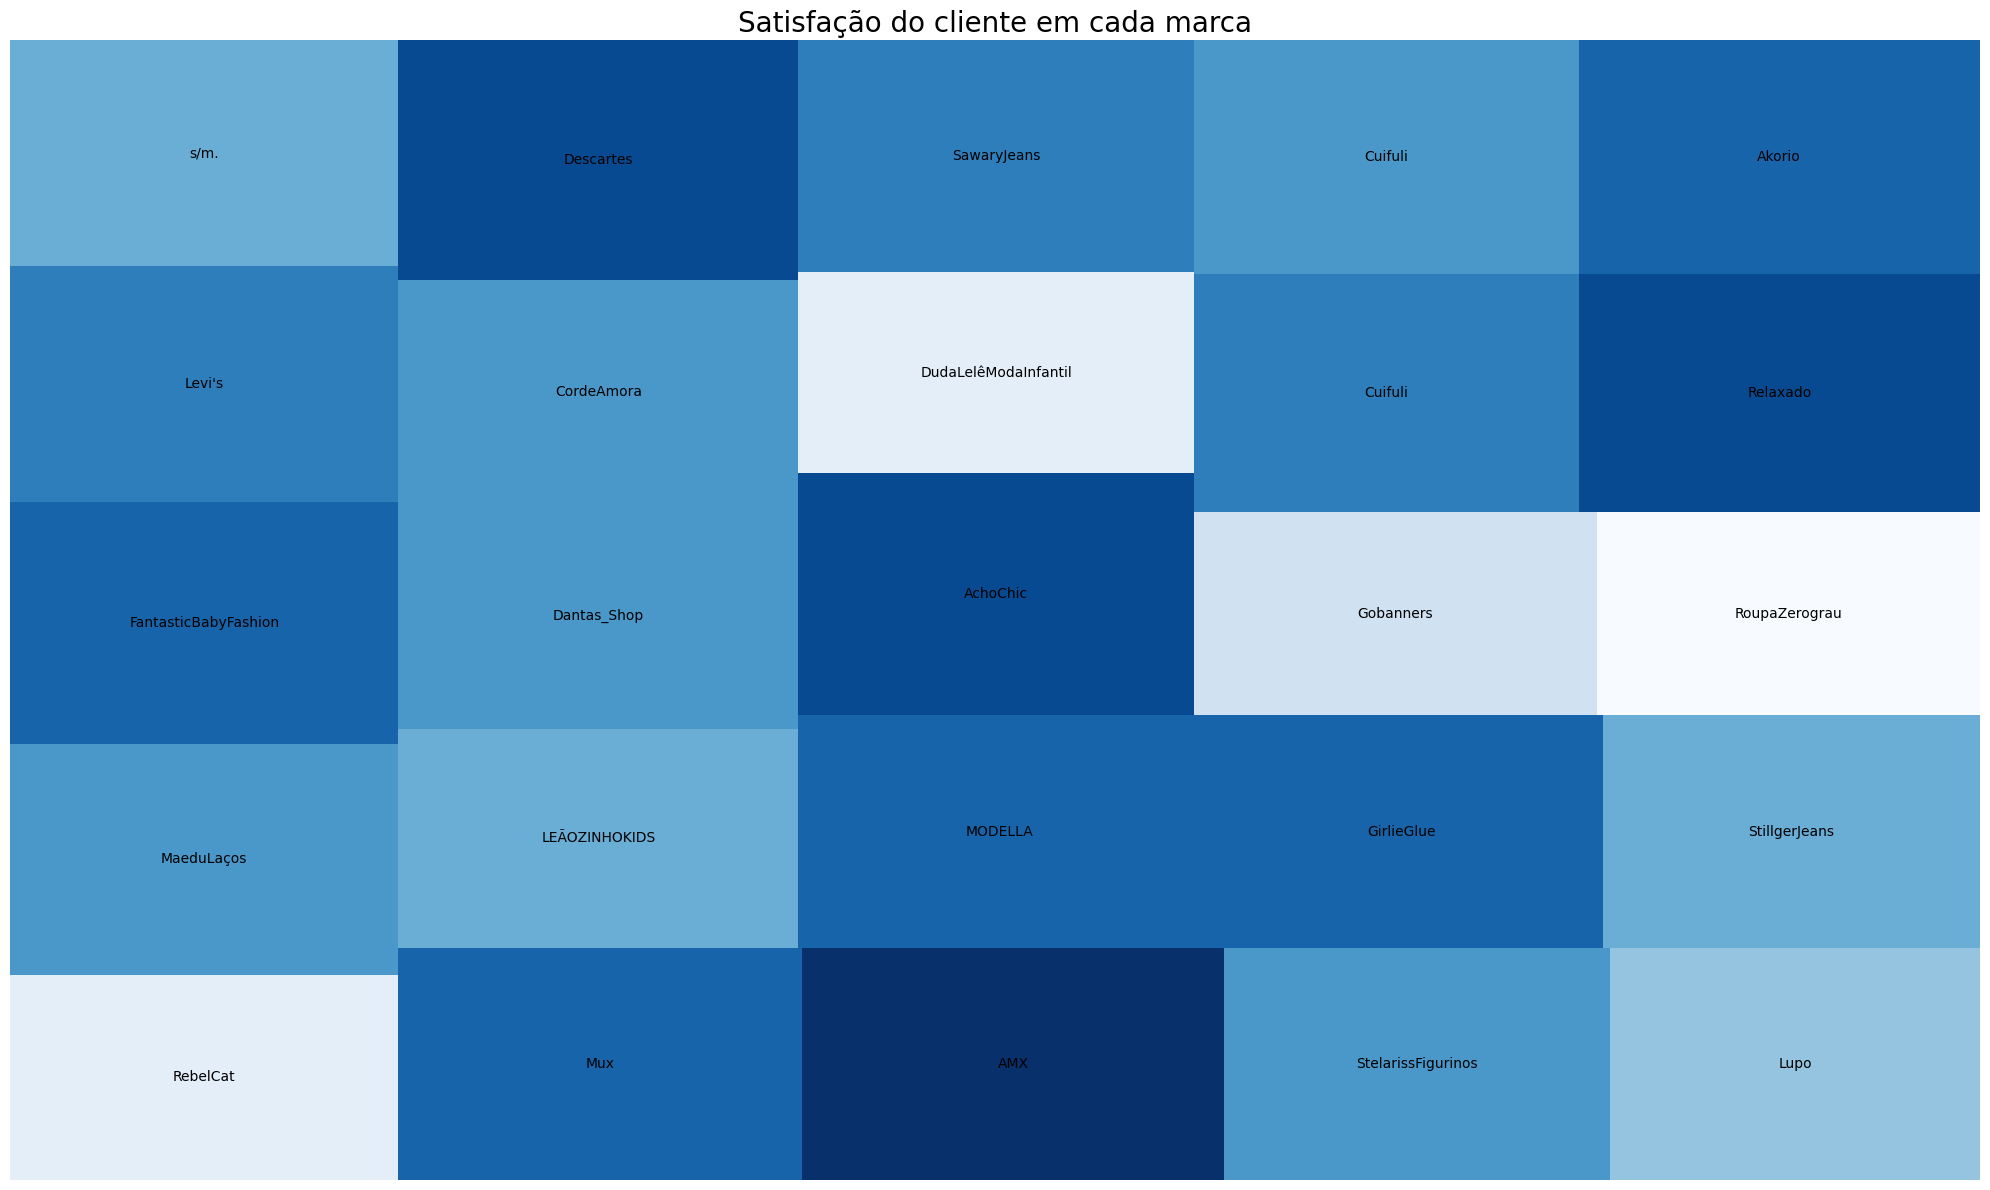

In [156]:
import matplotlib
import squarify

valores_y = [
    float(row[0].replace(',','.')) for row in
    roupas.limit(25).select("nota").collect()
]

# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.Blues
mini = min(valores_y)
maxi = max(valores_y)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in valores_y]

plt.figure(figsize=(20, 12))
squarify.plot(sizes=valores_y, label=valores_x, color=colors);
plt.title('Satisfação do cliente em cada marca', fontsize=20)
plt.axis('off');
plt.tight_layout()

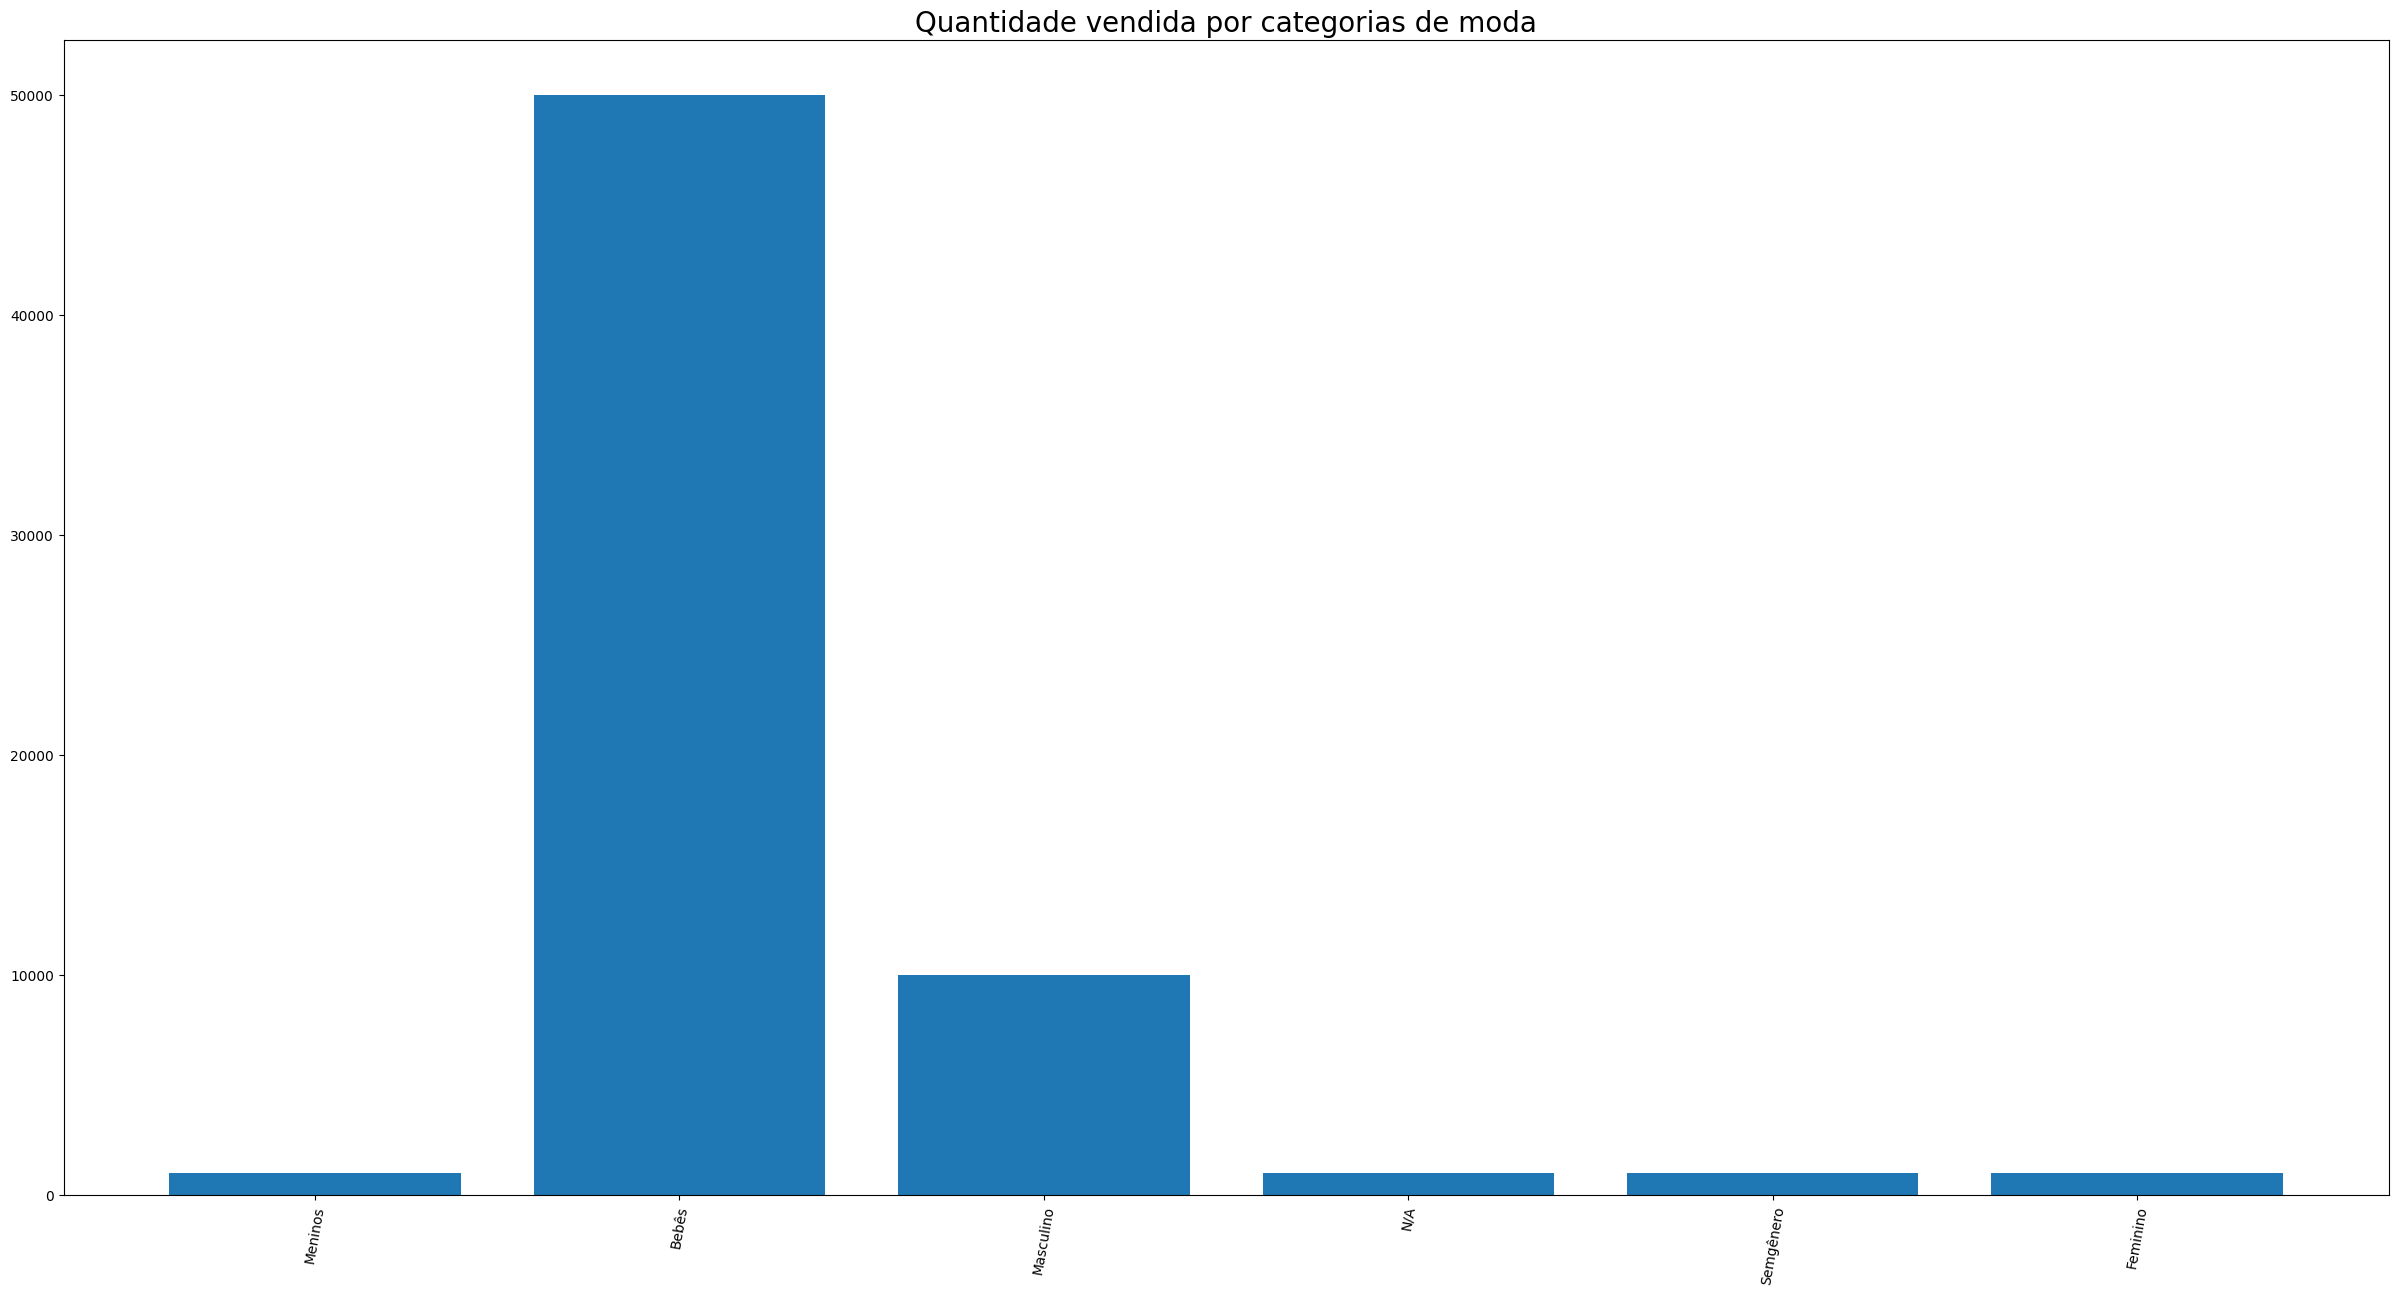

In [159]:
valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(20).select("gênero").collect()
]
valores_y = [
    float(row[0]) for row in
    roupas.na.drop("any").limit(20).select("n_vendidos_categoria").collect()
]
plt.figure(figsize=(30, 15))
plt.title("Quantidade vendida por categorias de moda", fontsize=20)
plt.bar(valores_x, valores_y)
plt.xticks(rotation=80)
plt.show()

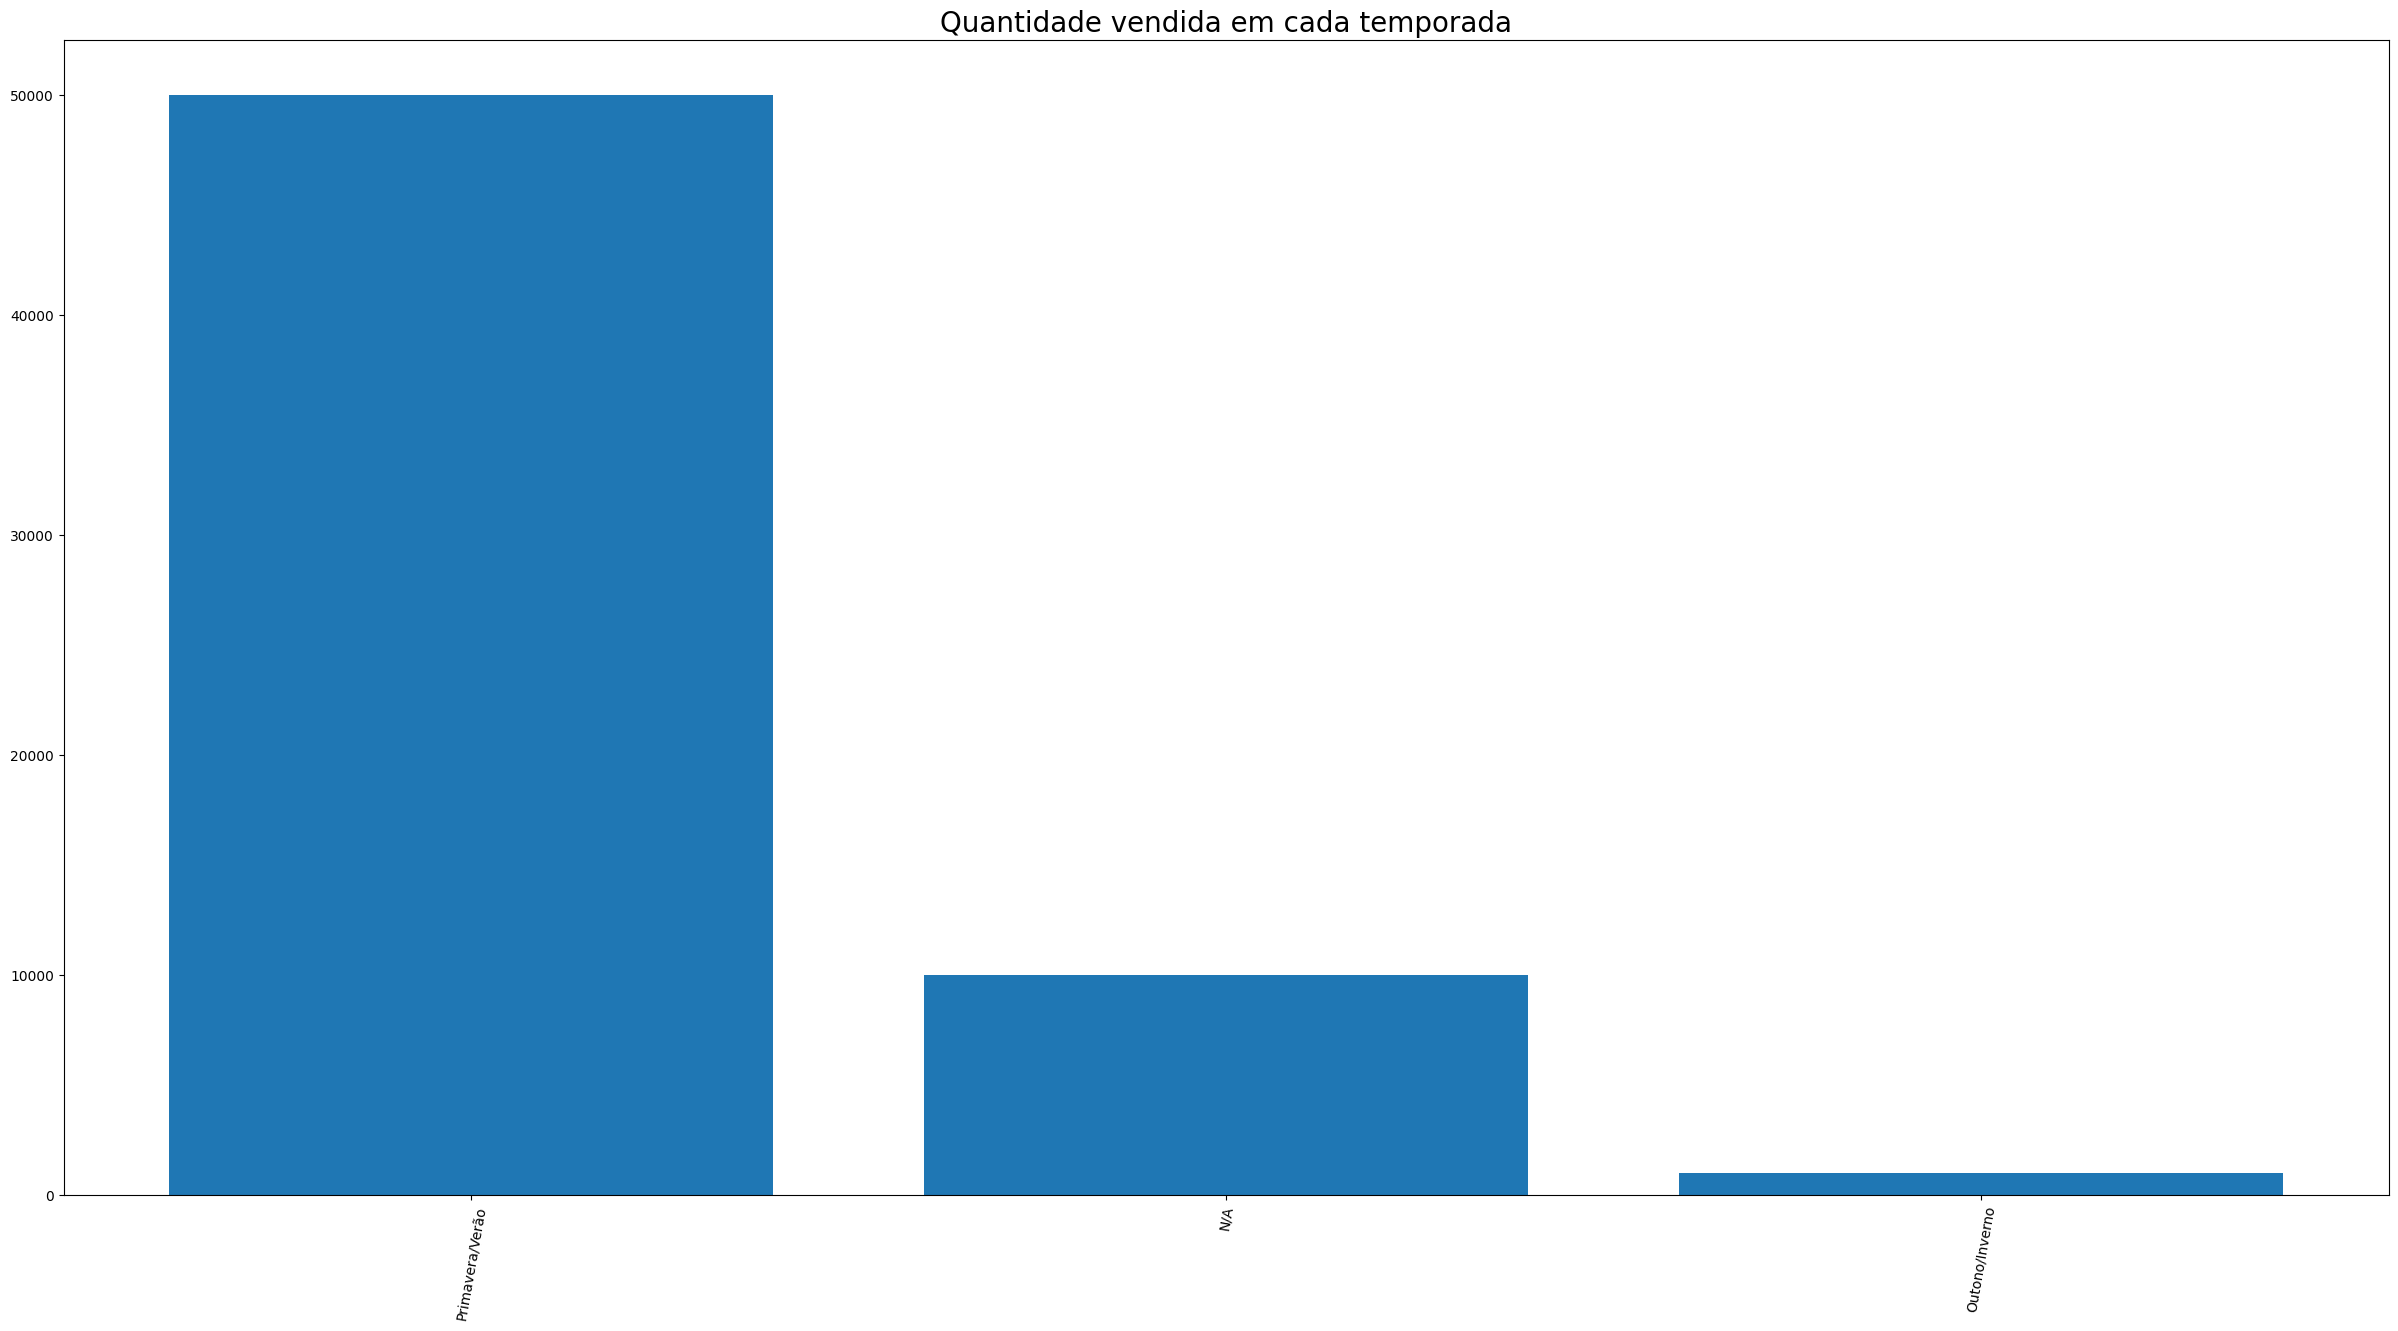

In [165]:
import matplotlib
import squarify
valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(20).select("temporada").collect()
]
valores_y = [
    float(row[0]) for row in
    roupas.na.drop("any").limit(20).select("n_vendidos_categoria").collect()
]
# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.Blues
maxi = max(valores_y)
norm = matplotlib.colors.Normalize(vmin=0, vmax=maxi)
colors = [cmap(norm(i)) for i in valores_y]

plt.figure(figsize=(30, 15))
plt.title("Quantidade vendida em cada temporada", fontsize=20)
plt.bar(valores_x, valores_y)
plt.xticks(rotation=80)
plt.show()